**Importing necessary libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Duration Analysis

In [8]:
def macaulay_duration(cash_flows, present_values):
    """
    Calculate the Macaulay duration of a series of cash flows.
    
    Args:
    cash_flows (array-like): Array of cash flows.
    present_values (array-like): Array of present values corresponding to cash flows.
    
    Returns:
    float: Macaulay duration.
    """
    numerator = np.sum([t * cf for t, cf in enumerate(cash_flows, start=1)])
    denominator = np.sum(present_values)
    duration = numerator / denominator
    return duration

def modified_duration(macaulay_duration, yield_to_maturity, coupon_frequency):
    """
    Calculate the modified duration.
    
    Args:
    macaulay_duration (float): Macaulay duration.
    yield_to_maturity (float): Yield to maturity.
    coupon_frequency (int): Number of coupon payments per year.
    
    Returns:
    float: Modified duration.
    """
    modified_duration = macaulay_duration / (1 + (yield_to_maturity / coupon_frequency))
    return modified_duration

def key_rate_duration(cash_flows, present_values, yield_changes):
    """
    Calculate the key rate duration for a given set of yield changes.
    
    Args:
    cash_flows (array-like): Array of cash flows.
    present_values (array-like): Array of present values corresponding to cash flows.
    yield_changes (array-like): Array of yield changes (in decimal form) for each key rate.
    
    Returns:
    array: Array of key rate durations.
    """
    key_rate_durations = []
    for yield_change in yield_changes:
        new_present_values = [pv / (1 + yield_change) for pv in present_values]
        new_macaulay_duration = macaulay_duration(cash_flows, new_present_values)
        key_rate_durations.append(new_macaulay_duration)
    return key_rate_durations

# Example usage:
cash_flows = [100, 100, 100, 100, 1000]  # Example cash flows
present_values = [cf / (1 + 0.05)**(t+1) for t, cf in enumerate(cash_flows)]  # Calculate present values
yield_to_maturity = 0.05  # Example yield to maturity
coupon_frequency = 1  # Example coupon frequency
yield_changes = [0.01, -0.01]  # Example yield changes for key rates

# Calculate Macaulay duration
macaulay_dur = macaulay_duration(cash_flows, present_values)
print("Macaulay Duration:", macaulay_dur)

# Calculate Modified duration
mod_dur = modified_duration(macaulay_dur, yield_to_maturity, coupon_frequency)
print("Modified Duration:", mod_dur)

# Calculate Key rate duration
key_rate_dur = key_rate_duration(cash_flows, present_values, yield_changes)
print("Key Rate Durations:", key_rate_dur)

Macaulay Duration: 5.271846189128615
Modified Duration: 5.020805894408205
Key Rate Durations: [5.324564651019901, 5.219127727237329]


## Vasicek Model

Using Monte-Carlo we simulate different interest rate paths possible using the Vasicek model. We then calculate the Macaulay duration and modified duration for each path:

In [10]:
def vasicek_model(n_simulations, n_steps, r0, mu, kappa, sigma, dt):
    """
    Simulate interest rate paths using the Vasicek model.
    
    Args:
    n_simulations (int): Number of simulation paths.
    n_steps (int): Number of time steps.
    r0 (float): Initial interest rate.
    mu (float): Long-term mean interest rate.
    kappa (float): Speed of mean reversion.
    sigma (float): Volatility.
    dt (float): Time step size.
    
    Returns:
    array: Array of simulated interest rate paths.
    """
    # Initialize array to store simulated paths
    paths = np.zeros((n_simulations, n_steps))
    paths[:, 0] = r0
    
    # Generate interest rate paths
    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), size=n_simulations)
        paths[:, i] = paths[:, i-1] + kappa * (mu - paths[:, i-1]) * dt + sigma * dW
        
    return paths

**Simulation:**

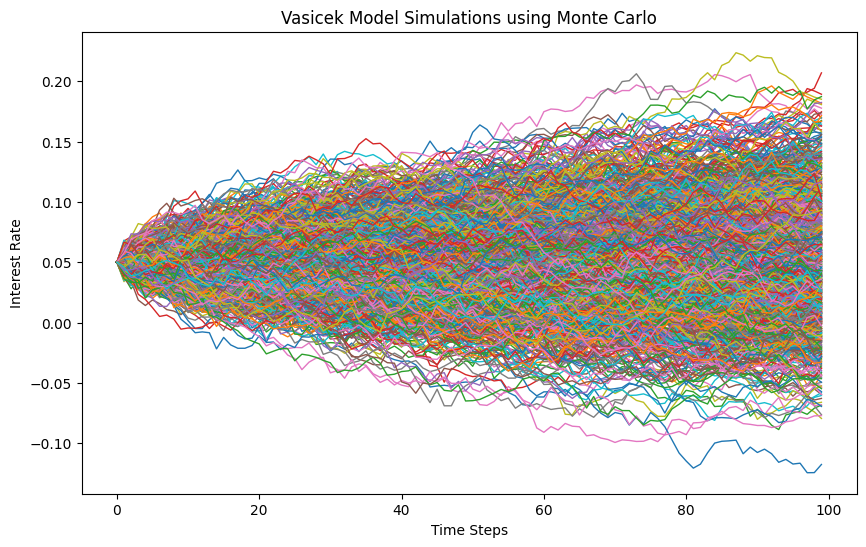

In [13]:
# Parameters
n_simulations = 1000  # Number of simulation paths
n_steps = 100  # Number of time steps
r0 = 0.05  # Initial interest rate
mu = 0.04  # Long-term mean interest rate
kappa = 0.1  # Speed of mean reversion
sigma = 0.1  # Volatility
dt = 1/365  # Time step size (1 day)

# Simulate interest rate paths
interest_rate_paths = vasicek_model(n_simulations, n_steps, r0, mu, kappa, sigma, dt)

# Plot interest rate paths
plt.figure(figsize=(10, 6))
plt.plot(interest_rate_paths.T, lw=1)
plt.title('Vasicek Model Simulations using Monte Carlo')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate')
plt.show()